In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, log_loss
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay

In [72]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
df = pd.read_excel('a_Dataset_CreditScoring.xlsx')

In [73]:
df = df.drop('ID', axis=1, errors='ignore')
row_threshold = len(df.columns) / 2
df = df.dropna(thresh=row_threshold, axis=0)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())
column_threshold = 0.95 * len(df)
df = df.loc[:, df.isnull().sum() < column_threshold]

In [74]:
print("\nFinal Missing Values:\n", df.isnull().sum())
print("\nDataset Shape After Cleaning:", df.shape)


Final Missing Values:
 TARGET             0
DerogCnt           0
CollectCnt         0
BanruptcyInd       0
InqCnt06           0
InqTimeLast        0
InqFinanceCnt24    0
TLTimeFirst        0
TLTimeLast         0
TLCnt03            0
TLCnt12            0
TLCnt24            0
TLCnt              0
TLSum              0
TLMaxSum           0
TLSatCnt           0
TLDel60Cnt         0
TLBadCnt24         0
TL75UtilCnt        0
TL50UtilCnt        0
TLBalHCPct         0
TLSatPct           0
TLDel3060Cnt24     0
TLDel90Cnt24       0
TLDel60CntAll      0
TLOpenPct          0
TLBadDerogCnt      0
TLDel60Cnt24       0
TLOpen24Pct        0
dtype: int64

Dataset Shape After Cleaning: (3000, 29)


In [75]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])
categorical_columns = X.select_dtypes(include=['object']).columns
continuous_columns = X.select_dtypes(exclude=['object']).columns

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [77]:
ohe = OneHotEncoder()
ohe.fit(X_train[categorical_columns])
X_train_categorical = ohe.transform(X_train[categorical_columns]).toarray()
X_test_categorical = ohe.transform(X_test[categorical_columns]).toarray()

scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.transform(X_test[continuous_columns])

X_train_transformed = np.hstack([X_train_continuous, X_train_categorical])
X_test_transformed = np.hstack([X_test_continuous, X_test_categorical])

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_transformed)
X_test_poly = poly.transform(X_test_transformed)

selector = SelectFromModel(LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000))
selector.fit(X_train_poly, y_train)
X_train_sel = selector.transform(X_train_poly)
X_test_sel = selector.transform(X_test_poly)

In [78]:
base_lr = LogisticRegression(random_state=0)
base_lr.fit(X_train_sel, y_train)

LogisticRegression(random_state=0)

In [79]:
y_pred_base_lr = base_lr.predict(X_test_sel)
y_pred_lr_proba = base_lr.predict_proba(X_test_sel)[:, 1]

print("Logistic Regression(Base) Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_base_lr))
print("Precision:", precision_score(y_test, y_pred_base_lr, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_base_lr, average="weighted"))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_lr_proba))
print("Log Loss:", log_loss(y_test, y_pred_lr_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_base_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_base_lr))

Logistic Regression(Base) Metrics:
Accuracy: 0.8322222222222222
Precision: 0.8044835400352943
Recall: 0.8322222222222222
ROC AUC Score: 0.7561422222222223
Log Loss: 0.43804754352152686

Confusion Matrix:
 [[708  42]
 [109  41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       750
           1       0.49      0.27      0.35       150

    accuracy                           0.83       900
   macro avg       0.68      0.61      0.63       900
weighted avg       0.80      0.83      0.81       900



In [80]:
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear'], 'class_weight': [None, 'balanced']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear'], 'class_weight': [None, 'balanced']},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1], 'solver': ['saga'], 'class_weight': [None, 'balanced'], 'l1_ratio': [0.25, 0.5, 0.75]}
]

grid_search = GridSearchCV(
    LogisticRegression(max_iter=3000),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_sel, y_train)

best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV:", best_params)

Best Parameters from GridSearchCV: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.75, 'penalty': 'elasticnet', 'solver': 'saga'}


In [81]:
classifier = LogisticRegression(
    random_state=0,
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    class_weight=best_params['class_weight'],
    max_iter=5000,
    l1_ratio=best_params['l1_ratio'] if 'l1_ratio' in best_params else None
)
classifier.fit(X_train_sel, y_train)

LogisticRegression(C=0.1, l1_ratio=0.75, max_iter=5000, penalty='elasticnet',
                   random_state=0, solver='saga')

In [82]:
y_pred = classifier.predict(X_test_sel)
y_pred_proba = classifier.predict_proba(X_test_sel)[:, 1]

In [83]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8366666666666667
Precision: 0.7989878157987571
Recall: 0.8366666666666667
ROC AUC Score: 0.7741155555555556
Log Loss: 0.38756330738461714

Confusion Matrix:
 [[730  20]
 [127  23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       750
           1       0.53      0.15      0.24       150

    accuracy                           0.84       900
   macro avg       0.69      0.56      0.57       900
weighted avg       0.80      0.84      0.80       900



In [84]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42
)
xgb_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [85]:
y_scores = xgb_model.predict_proba(X_test_transformed)[:, 1]
threshold = 0.3

y_pred_adj = (y_scores >= threshold).astype(int)

print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_adj))
print("Precision:", precision_score(y_test, y_pred_adj, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_adj, average="weighted"))
print("ROC AUC Score:", roc_auc_score(y_test, y_scores))
print("Log Loss:", log_loss(y_test, y_scores))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_adj))
print("\nClassification Report:\n", classification_report(y_test, y_pred_adj))

XGBoost Metrics:
Accuracy: 0.8133333333333334
Precision: 0.8073719045988818
Recall: 0.8133333333333334
ROC AUC Score: 0.7623377777777778
Log Loss: 0.5182866413279915

Confusion Matrix:
 [[672  78]
 [ 90  60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       750
           1       0.43      0.40      0.42       150

    accuracy                           0.81       900
   macro avg       0.66      0.65      0.65       900
weighted avg       0.81      0.81      0.81       900



In [86]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_sel, y_train)

RandomForestClassifier(random_state=0)

In [87]:
y_pred_rf = rf_model.predict(X_test_sel)
y_pred_rf_proba = rf_model.predict_proba(X_test_sel)[:, 1]

print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_rf, average="weighted"))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf_proba))
print("Log Loss:", log_loss(y_test, y_pred_rf_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Metrics:
Accuracy: 0.8288888888888889
Precision: 0.7769551238509261
Recall: 0.8288888888888889
ROC AUC Score: 0.7637911111111112
Log Loss: 0.4597111518940437

Confusion Matrix:
 [[731  19]
 [135  15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       750
           1       0.44      0.10      0.16       150

    accuracy                           0.83       900
   macro avg       0.64      0.54      0.53       900
weighted avg       0.78      0.83      0.78       900



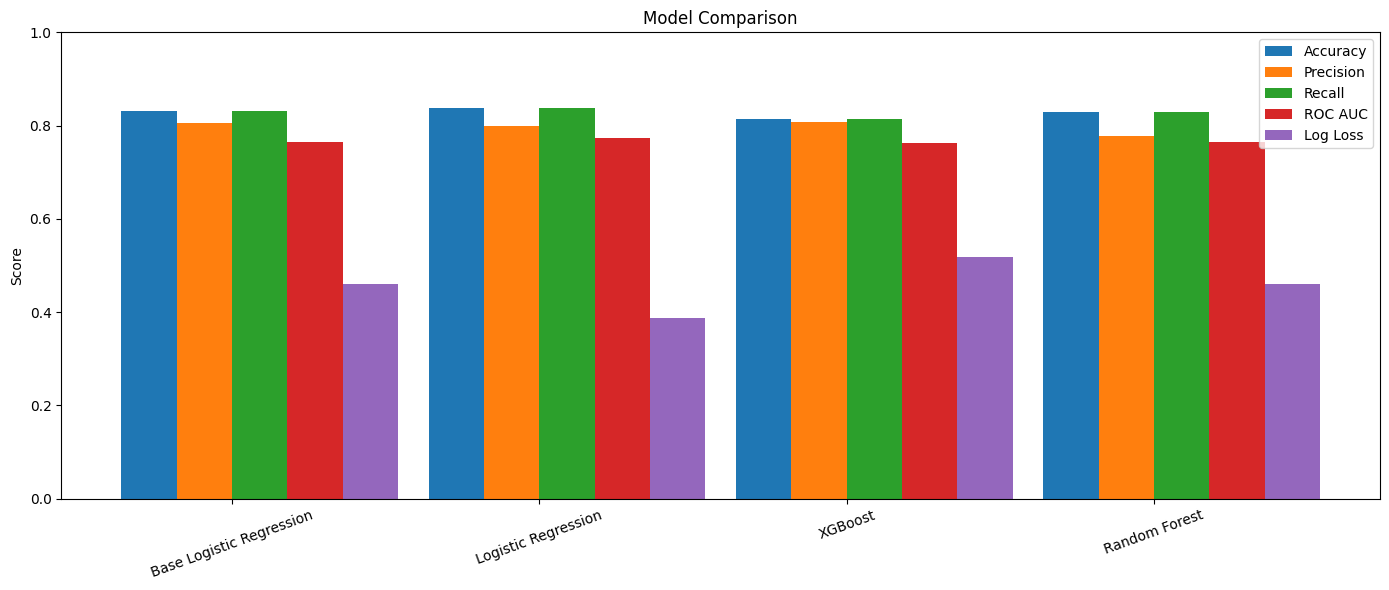

In [88]:
model_names = [
    'Base Logistic Regression', 'Logistic Regression', 'XGBoost', 'Random Forest',
]

accuracy = [
    accuracy_score(y_test, y_pred_base_lr),  
    accuracy_score(y_test, y_pred),           
    accuracy_score(y_test, y_pred_adj),       
    accuracy_score(y_test, y_pred_rf),             
]

precision = [
    precision_score(y_test, y_pred_base_lr, average="weighted", zero_division=0),
    precision_score(y_test, y_pred, average="weighted", zero_division=0),
    precision_score(y_test, y_pred_adj, average="weighted", zero_division=0),
    precision_score(y_test, y_pred_rf, average="weighted", zero_division=0),
]

recall = [
    recall_score(y_test, y_pred_base_lr, average="weighted"),
    recall_score(y_test, y_pred, average="weighted"),
    recall_score(y_test, y_pred_adj, average="weighted"),
    recall_score(y_test, y_pred_rf, average="weighted"),
]

roc_auc = [
    roc_auc_score(y_test, y_pred_rf_proba),        
    roc_auc_score(y_test, y_pred_proba),            
    roc_auc_score(y_test, y_scores),              
    roc_auc_score(y_test, y_pred_rf_proba),                
]

log_loss = [
    log_loss(y_test, y_pred_rf_proba),        
    log_loss(y_test, y_pred_proba),            
    log_loss(y_test, y_scores),              
    log_loss(y_test, y_pred_rf_proba),            
]

x = np.arange(len(model_names))
width = 0.18

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, roc_auc, width, label='ROC AUC')
rects5 = ax.bar(x + 2.5*width, log_loss, width, label='Log Loss')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=20)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

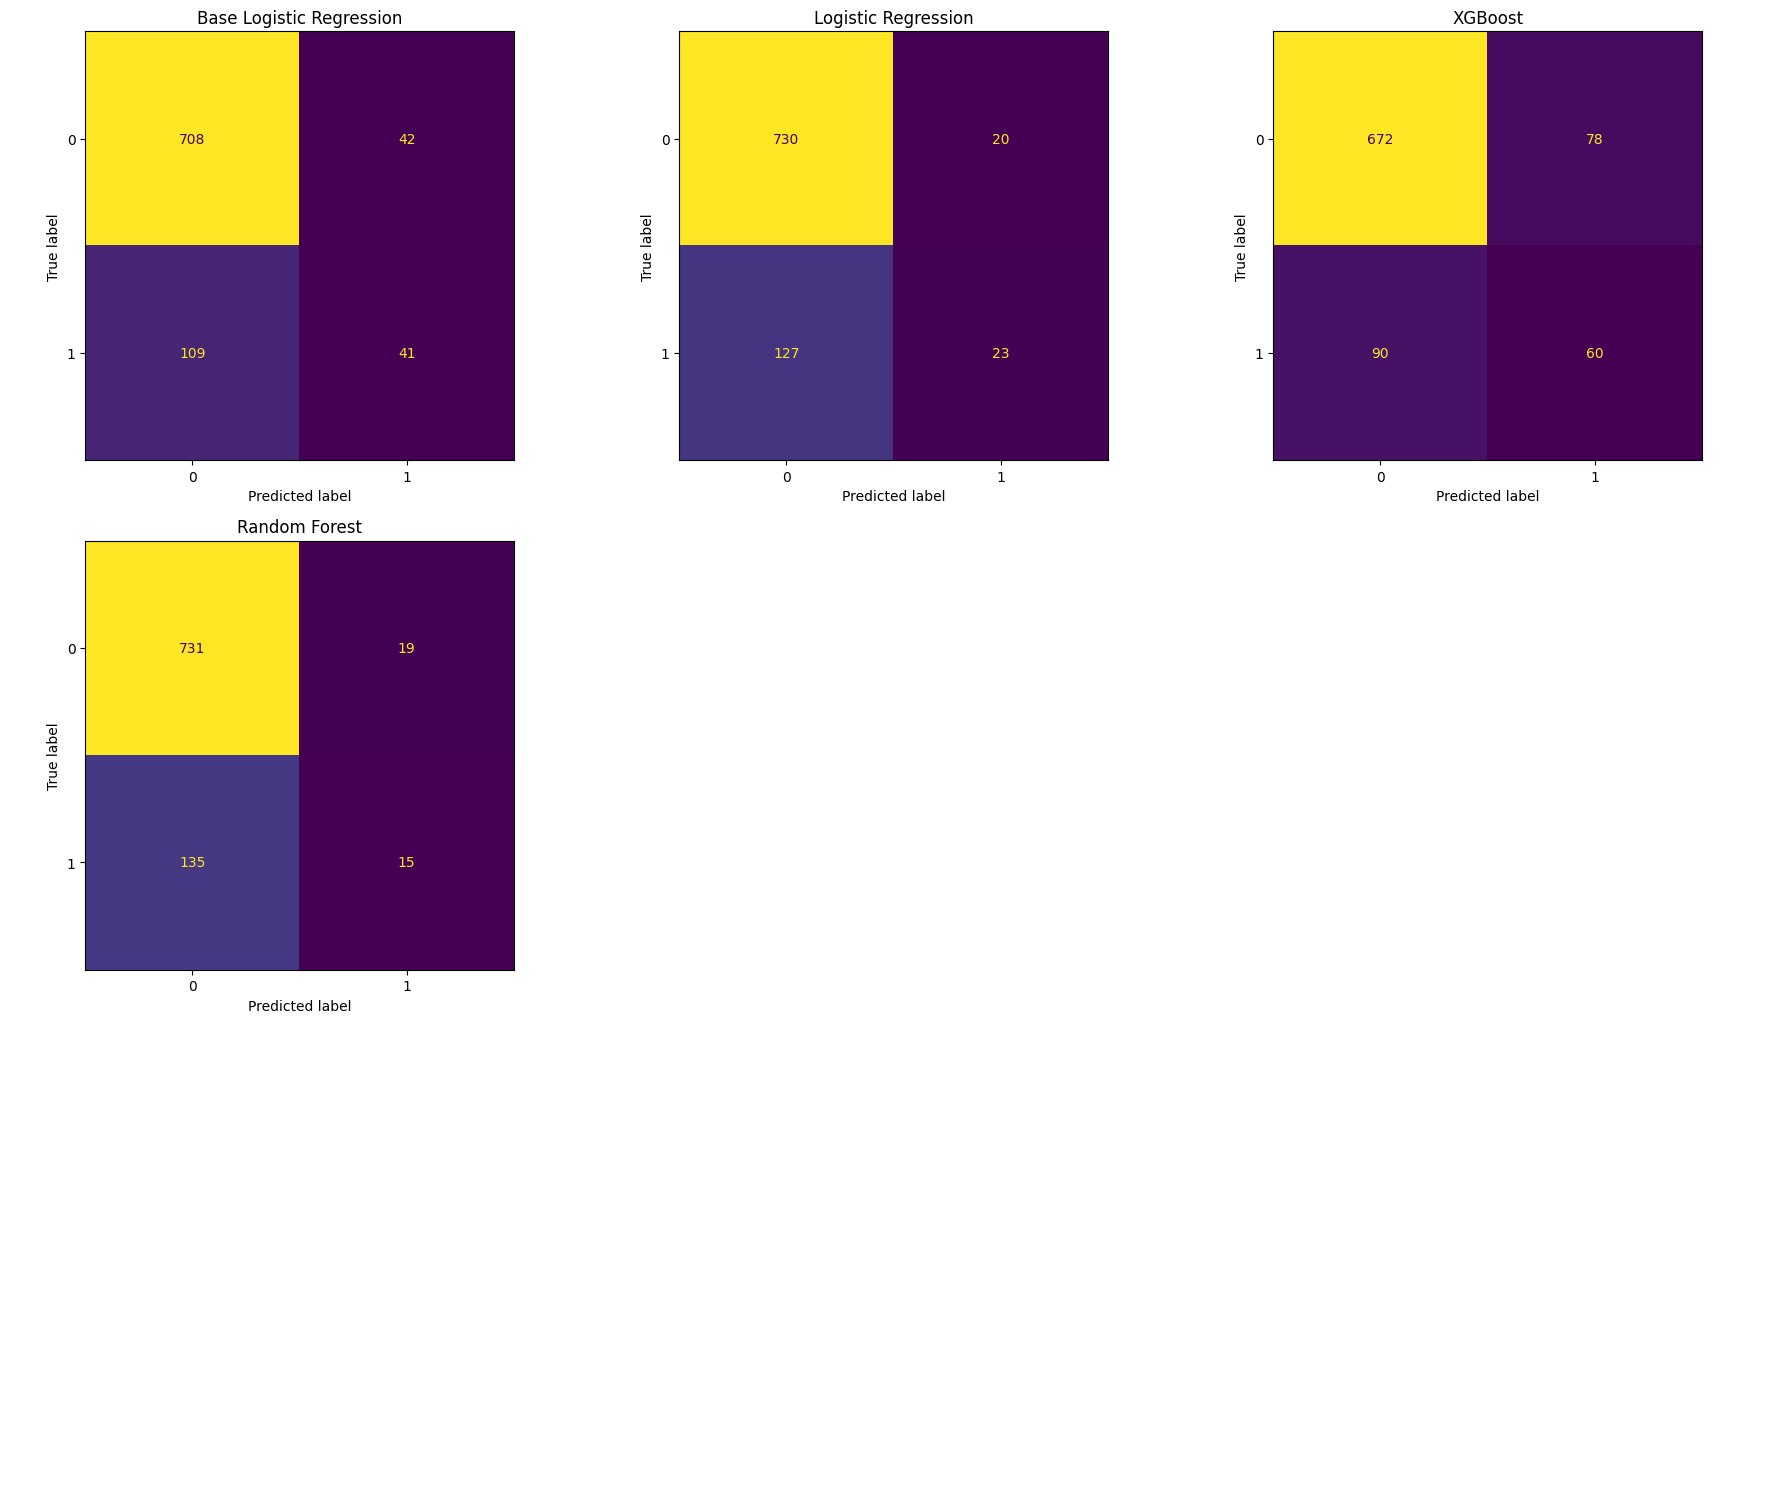

In [89]:
model_names = [
    'Base Logistic Regression', 'Logistic Regression', 'XGBoost', 'Random Forest',
]
y_preds = [
    y_pred_base_lr, 
    y_pred,         
    y_pred_adj,     
    y_pred_rf,        
]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (name, y_p) in enumerate(zip(model_names, y_preds)):
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_p, ax=axes[idx], colorbar=False
    )
    axes[idx].set_title(name)

for j in range(len(model_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

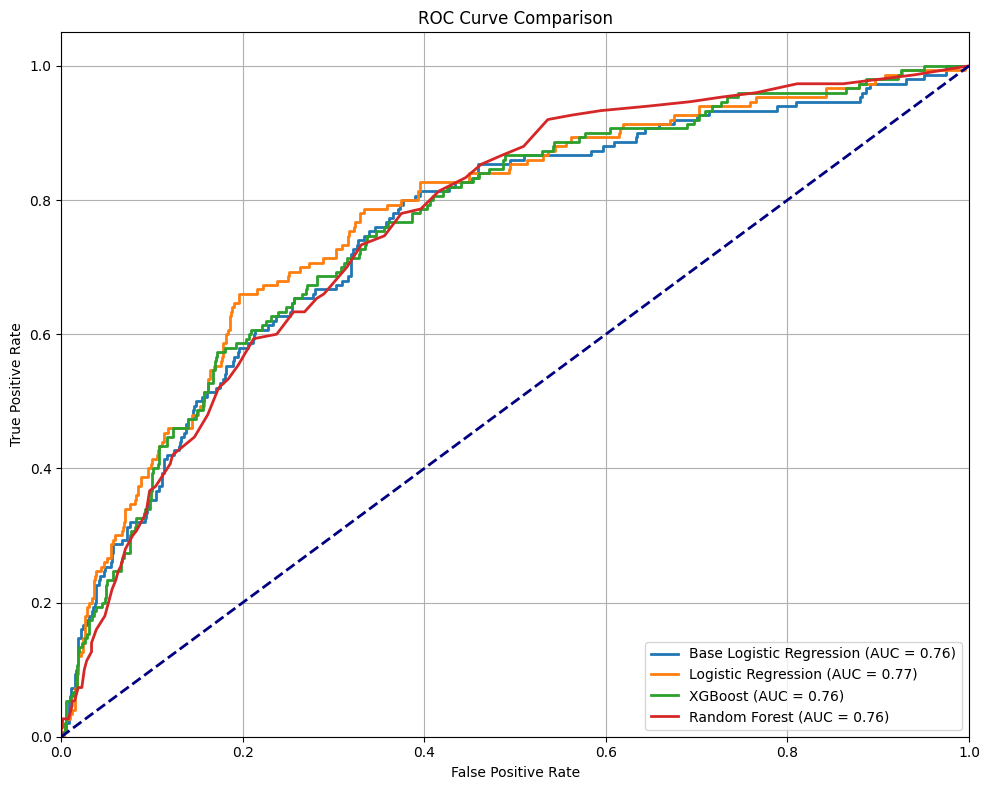

In [93]:
plt.figure(figsize=(10, 8))

model_names = [
    'Base Logistic Regression', 'Logistic Regression', 'XGBoost', 'Random Forest'
]
probas = [
    y_pred_lr_proba,  
    y_pred_proba,      
    y_scores,          
    y_pred_rf_proba,   
]

for name, y_score in zip(model_names, probas):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

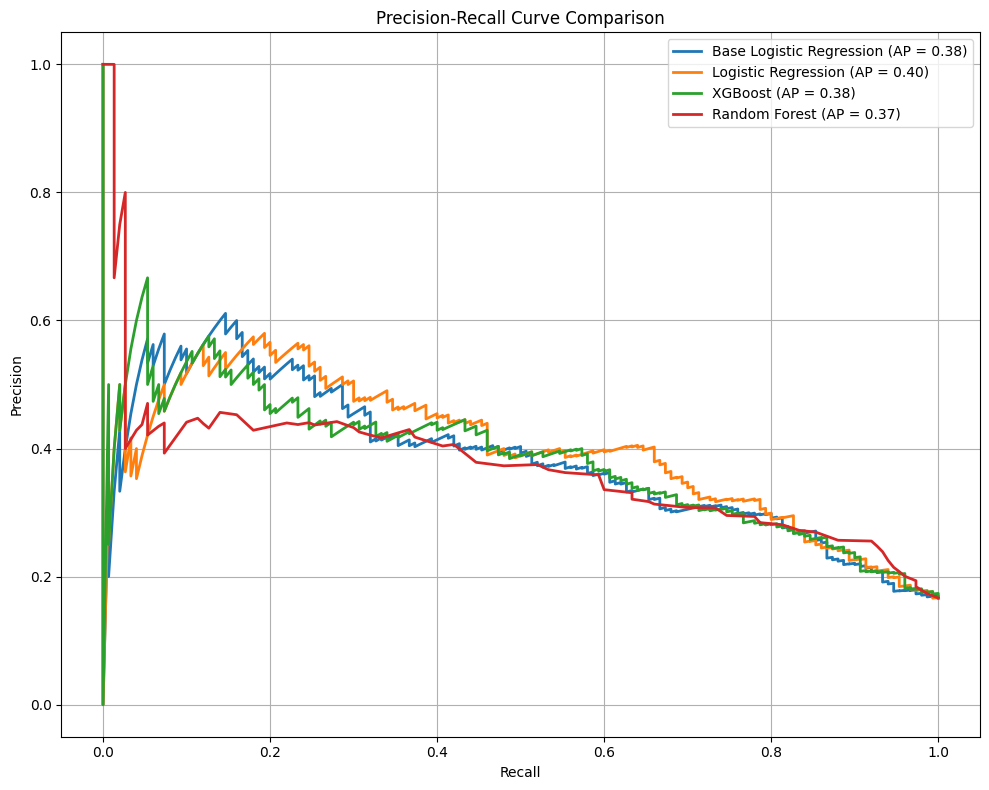

In [94]:
plt.figure(figsize=(10, 8))

for name, y_score in zip(model_names, probas):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_prec = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_prec:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

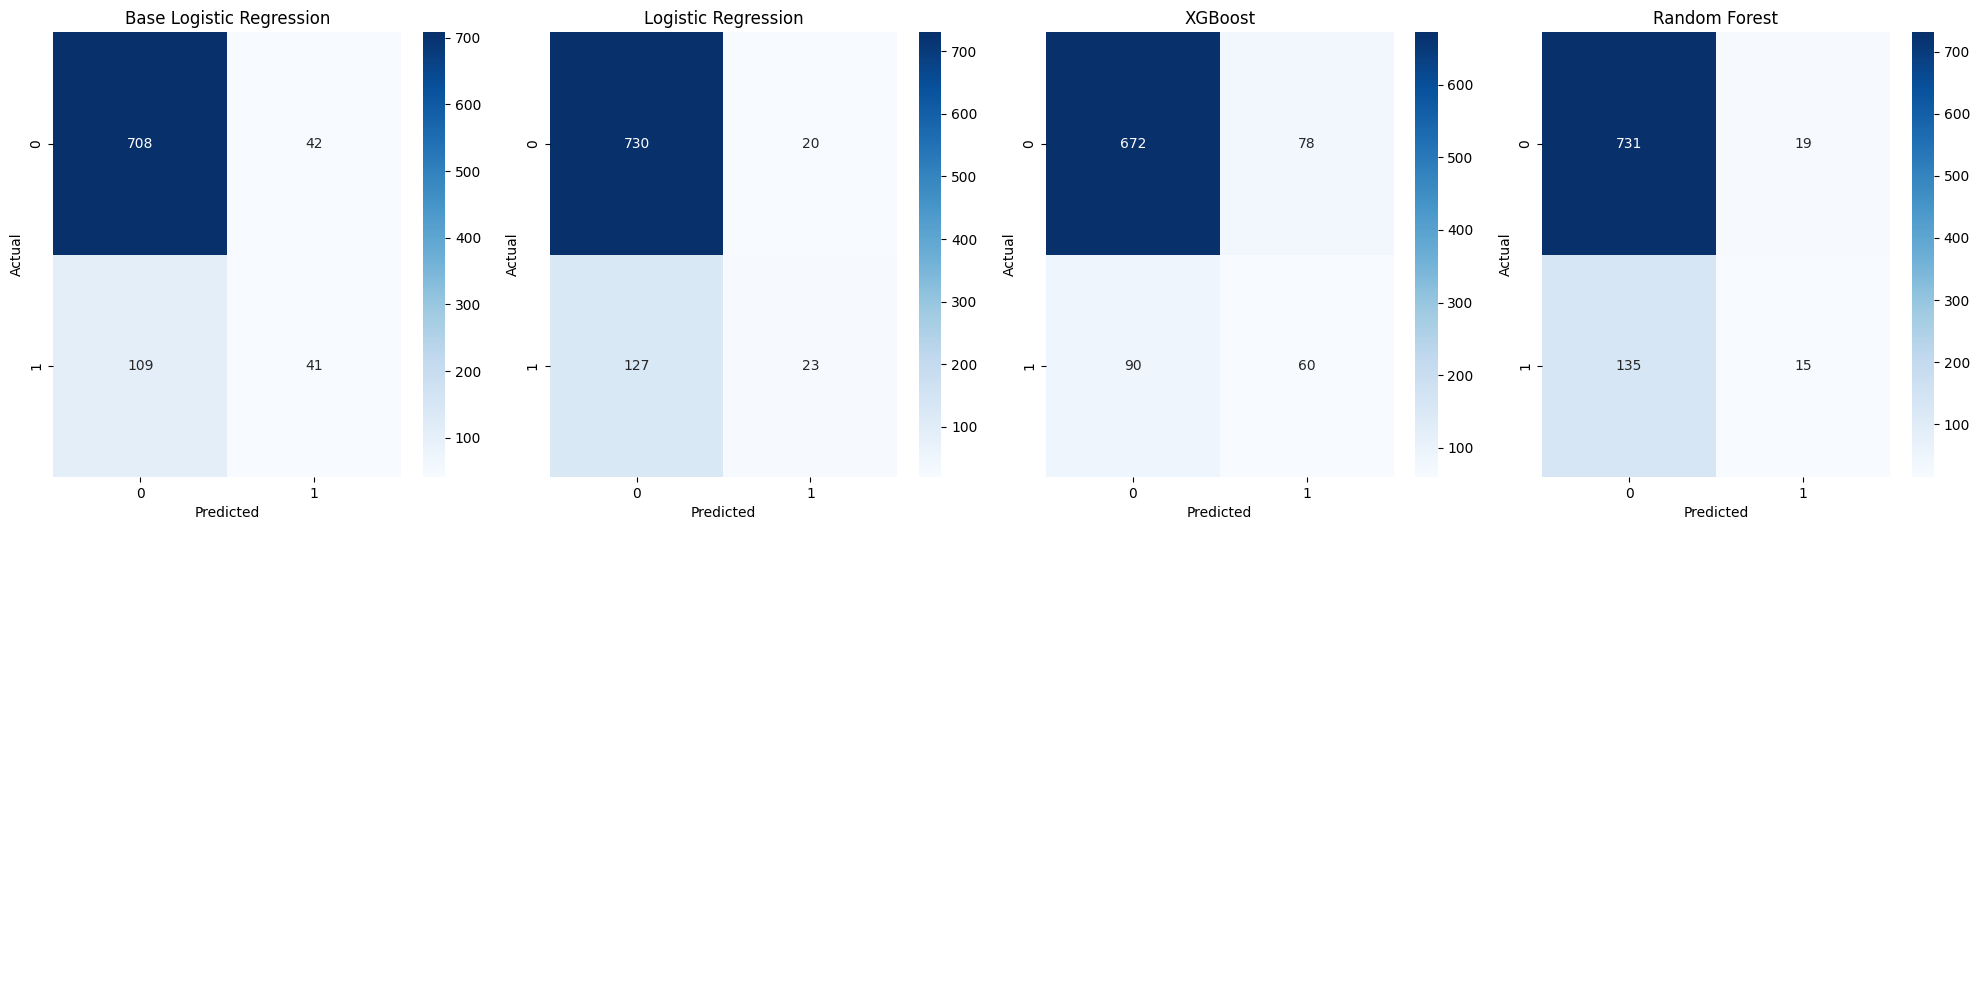

In [92]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for idx, (name, y_p) in enumerate(zip(model_names, y_preds)):
    cm = confusion_matrix(y_test, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
for j in range(len(model_names), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()